In [1]:
import tablib
import ujson as json
import pyexcel as pe
import pandas as pd
from time import perf_counter
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
import numpy as np
from typing import Generator, Dict, List, Set, Any
from pprint import pprint
from collections import OrderedDict, defaultdict

In [2]:
filePath = r'C:\OmicData\LiGroupWork\PDBeAPI\0117\4w9p_residue_listing.json'
with open(filePath, 'r') as jsonFile:
    data = json.load(jsonFile)

In [2]:
def performance(record: List, func, *args):
    t0 = perf_counter()
    res = func(*args)
    del res
    cost = perf_counter() - t0
    record.append(cost)

In [4]:
 def yieldResidues(data: Dict) -> Generator:
    for pdb in data:
        molecules = data[pdb]['molecules']
        for entity in molecules:
            chains = entity['chains']
            for chain in chains:
                residues = chain['residues']
                yield residues, chain['chain_id'], chain['struct_asym_id'], entity['entity_id'], pdb

In [5]:
def sync_with_pyexcel(residues, chain_id, struct_asym_id, entity_id, pdb_id):
    sheet = pe.get_sheet(records=residues, name_columns_by_row=0)
    append_data = [['chain_id', 'struct_asym_id', 'entity_id', 'pdb_id']] + [[chain_id, struct_asym_id, entity_id, pdb_id]]*len(residues)
    sheet.column += pe.Sheet(append_data)
    return sheet

def sync_with_dataframe(residues, chain_id, struct_asym_id, entity_id, pdb_id):
    dfrm = pd.DataFrame(residues)
    dfrm['pdb_id'] = pdb_id
    dfrm['entity_id'] = entity_id
    dfrm['struct_asym_id'] = struct_asym_id
    dfrm['chain_id'] = chain_id
    return dfrm

In [6]:
 def pyexcel_io(data: Dict, kwargs):
    for res in yieldResidues(data):
        try:
            cur_sheet.row += sync_with_pyexcel(*res)
        except NameError:
            cur_sheet = sync_with_pyexcel(*res)
    cur_sheet.save_as(**kwargs)
    return cur_sheet
    

def pandas_concat_io(data: Dict, kwargs):
    dfrm = pd.concat((sync_with_dataframe(*res) for res in yieldResidues(data)), sort=False)
    dfrm.to_csv(**kwargs)
    return dfrm

def pandas_append_io(data: Dict, kwargs):
    dfrm = None
    for res in yieldResidues(data):
        try:
            dfrm = dfrm.append(sync_with_dataframe(*res) , ignore_index=True, sort=False)
        except AttributeError:
            dfrm = sync_with_dataframe(*res) 
    dfrm.to_csv(**kwargs)
    return dfrm

In [7]:
# sheet.save_as(filename=r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\sheet_0214.tsv', delimiter='\t')
# pyexcel_io(data)
# pandas_concat_io(data)
# pandas_append_io(data)
pyexcel_io_perf, pandas_concat_io_perf, pandas_append_io_perf = [], [], []

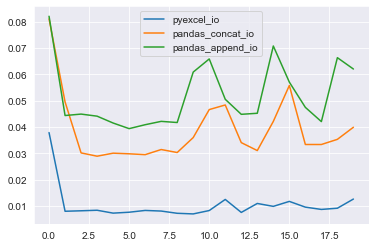

In [8]:
for _ in range(20):
    performance(
        pyexcel_io_perf, 
        pyexcel_io, 
        data, 
        {'filename': r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\pyexcel_io_0214.tsv', 
        'delimiter': '\t'})
    performance(
        pandas_concat_io_perf, 
        pandas_concat_io, 
        data, 
        {'path_or_buf': r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\pandas_concat_io_0214.tsv', 
        'sep': '\t', 
        'index': False})
    performance(
        pandas_append_io_perf, 
        pandas_append_io, 
        data,
        {'path_or_buf': r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\pandas_append_io_0214.tsv', 
        'sep': '\t', 
        'index': False})

len_x = len(pyexcel_io_perf)
plt.plot(list(range(len_x)), pyexcel_io_perf, label='pyexcel_io')
plt.plot(list(range(len_x)), pandas_concat_io_perf, label='pandas_concat_io')
plt.plot(list(range(len_x)), pandas_append_io_perf, label='pandas_append_io')
plt.legend()


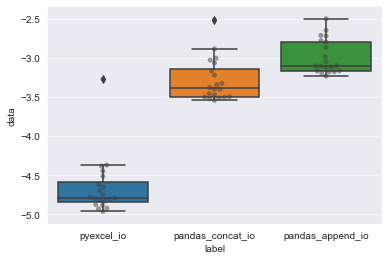

In [9]:
# boxplot
plot_dfrm = pd.DataFrame({'data': pyexcel_io_perf+pandas_concat_io_perf+pandas_append_io_perf, 'label':['pyexcel_io']*len_x + ['pandas_concat_io']*len_x + ['pandas_append_io']*len_x})
plot_dfrm['data'] = plot_dfrm['data'].apply(np.log)
sns.boxplot(x='label', y='data', data=plot_dfrm)
sns.swarmplot(x="label", y="data", data=plot_dfrm, color=".25", alpha=0.5)

In [10]:

ob = tablib.Dataset()

In [11]:
test = data['4w9p']['molecules'][0]['chains'][0]['residues']

In [12]:
# pe.get_sheet(records=test)
# pe.load_from_records(test)
ob.dict = test[50:70]

In [13]:
sheet = pe.get_sheet(records=test, name_columns_by_row=0)
lyst = [['pdb_id', 'chain_id']] + [['test_id', 'test_chain']]*len(test)
sheet.column += pe.Sheet(lyst)
sheet

author_insertion_code,author_residue_number,observed_ratio,residue_name,residue_number,pdb_id,chain_id
,13,0,GLY,1,test_id,test_chain
,14,0,ALA,2,test_id,test_chain
,15,0,PRO,3,test_id,test_chain
,16,0,ALA,4,test_id,test_chain
,17,0,THR,5,test_id,test_chain
,18,0,VAL,6,test_id,test_chain
,19,1,THR,7,test_id,test_chain
,20,1,GLU,8,test_id,test_chain
,21,1,GLN,9,test_id,test_chain
,22,1,GLY,10,test_id,test_chain


In [14]:
test[38:42]

[{'residue_number': 39,
  'author_residue_number': 51,
  'author_insertion_code': '',
  'residue_name': 'ASP',
  'observed_ratio': 1},
 {'residue_number': 40,
  'author_residue_number': 52,
  'author_insertion_code': '',
  'residue_name': 'LYS',
  'observed_ratio': 1},
 {'multiple_conformers': [{'residue_name': 'VAL', 'alternate_conformers': 2}],
  'residue_number': 41,
  'author_residue_number': 53,
  'author_insertion_code': '',
  'residue_name': 'VAL',
  'observed_ratio': 1},
 {'residue_number': 42,
  'author_residue_number': 54,
  'author_insertion_code': '',
  'residue_name': 'TYR',
  'observed_ratio': 1}]

In [18]:

pyexcel_lyst, dataframe_lyst, tablib_lyst = [], [], []

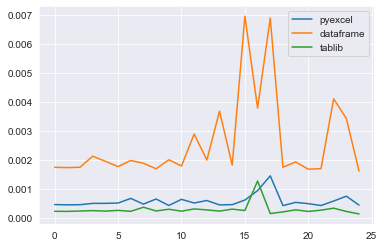

In [19]:
 for _ in range(25):
    t0 = perf_counter()
    pe.load_from_records(test[50:70])
    pyexcel_lyst.append(perf_counter() - t0)
    # 
    t0 = perf_counter()
    pd.DataFrame(test[50:70])
    dataframe_lyst.append(perf_counter() - t0)
    # 
    t0 = perf_counter()
    ob.dict = test[50:70]
    tablib_lyst.append(perf_counter() - t0)


len_x = len(pyexcel_lyst)
plt.plot(list(range(len_x)), pyexcel_lyst, label='pyexcel')
plt.plot(list(range(len_x)), dataframe_lyst, label='dataframe')
plt.plot(list(range(len_x)), tablib_lyst, label='tablib')
plt.legend()

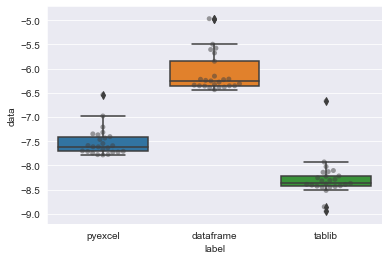

In [20]:

plot_dfrm = pd.DataFrame({'data': pyexcel_lyst+dataframe_lyst+tablib_lyst, 'label':['pyexcel']*len_x + ['dataframe']*len_x + ['tablib']*len_x})
plot_dfrm['data'] = plot_dfrm['data'].apply(np.log)
sns.boxplot(x='label', y='data', data=plot_dfrm)
sns.swarmplot(x="label", y="data", data=plot_dfrm, color=".25", alpha=0.5)
# sns.violinplot(x="label", y="data", data=plot_dfrm, alpha=0.5)

## 20200218

In [3]:
FUNCS = list()


def dispatch_on_set(keys: Set):
    """
    Decorator to add new dispatch functions
    """
    def register(func):
        FUNCS.append((func, set(keys)))
        return func
    return register


def traversePDBeData(query: Any, *args):
    for func, keySet in FUNCS:
        if query in keySet:
            return func(*args)


class PDBeDecoder(object):
    @staticmethod
    def sync_with_tablib(*args):
        records, *remain = args
        ob = tablib.Dataset()
        for index in range(len(records)):
            records[index] = OrderedDict(sorted(records[index].items()))
        ob.dict = records
        if len(remain) > 1:
            append_header, append_value = remain
            for i in range(len(append_value)):
                ob.append_col([append_value[i]]*len(records), append_header[i])
        return ob

    @classmethod
    def tablib_io(cls, suffix: str, data: Dict, **kwargs):
        cur_ob = None
        for res in traversePDBeData(suffix, data):
            try:
                cur_ob.dict += cls.sync_with_tablib(*res).dict
            except AttributeError:
                cur_ob = cls.sync_with_tablib(*res)
        del data
        return cur_ob
    
    @staticmethod
    def sync_with_pyexcel(*args):
        records, *remain = args
        sheet = pe.get_sheet(records=records, name_columns_by_row=0)
        if len(remain) > 1:
            append_header, append_value = remain
            append_data = [append_header] + [append_value]*len(records)
            sheet.column += pe.Sheet(append_data)
        return sheet

    @classmethod
    def pyexcel_io(cls, suffix: str, data: Dict, **kwargs):
        cur_sheet = None
        for res in traversePDBeData(suffix, data):
            try:
                cur_sheet.row += cls.sync_with_pyexcel(*res)
            except AttributeError:
                cur_sheet = cls.sync_with_pyexcel(*res)
        if kwargs:
            cur_sheet.save_as(**kwargs)
        del data
        return cur_sheet

    @staticmethod
    @dispatch_on_set({'/pdb/entry/status/', '/pdb/entry/summary/', '/pdb/entry/modified_AA_or_NA/',
                      '/pdb/entry/mutated_AA_or_NA/', '/pdb/entry/cofactor/', '/pdb/entry/molecules/',
                      '/pdb/entry/ligand_monomers/', '/pdb/entry/experiment/',
                      '/pdb/entry/electron_density_statistics/',
                      '/pdb/entry/related_experiment_data/', '/pdb/entry/drugbank/'})
    def yieldCommon(data: Dict) -> Generator:
        for pdb in data:
            values = data[pdb]
            # '''
            for value in values:
                for key in value:
                    if isinstance(value[key], (Dict, List)):
                        value[key] = json.dumps(value[key])
            # '''
            yield values, ('pdb_id',), (pdb,)

    @staticmethod
    @dispatch_on_set({'/pdb/entry/polymer_coverage/'})
    def yieldPolymerCoverage(data: Dict) -> Generator:
        for pdb in data:
            molecules = data[pdb]['molecules']
            for entity in molecules:
                chains = entity['chains']
                for chain in chains:
                    observed = chain['observed']
                    for fragement in observed:
                        for key in ('start', 'end'):
                            fragement[key] = json.dumps(fragement[key])
                    yield observed, ('chain_id', 'struct_asym_id', 'entity_id', 'pdb_id'), (chain['chain_id'], chain['struct_asym_id'], entity['entity_id'], pdb)        
    
    @staticmethod
    @dispatch_on_set({'/pdb/entry/residue_listing/'})
    def yieldResidues(data: Dict) -> Generator:
        for pdb in data:
            molecules = data[pdb]['molecules']
            for entity in molecules:
                chains = entity['chains']
                for chain in chains:
                    residues = chain['residues']
                    for res in residues:
                        if 'multiple_conformers' not in res:
                            res['multiple_conformers'] = None
                    yield residues, ('chain_id', 'struct_asym_id', 'entity_id', 'pdb_id'), (chain['chain_id'], chain['struct_asym_id'], entity['entity_id'], pdb)
    
    @staticmethod
    @dispatch_on_set({'/pdb/entry/observed_residues_ratio/'})
    def yieldObservedResiduesRatio(data: Dict) -> Generator:
        for pdb in data:
            for entity_id, entity in data[pdb].items():
                yield entity, ('entity_id', 'pdb_id'), (entity_id, pdb)
                  
    @staticmethod
    @dispatch_on_set({'/pdb/entry/secondary_structure/'})
    def yieldSecondaryStructure(data: Dict):
        for pdb in data:
            molecules = data[pdb]['molecules']
            for entity in molecules:
                chains = entity['chains']
                for chain in chains:
                    secondary_structure = chain['secondary_structure']
                    for name in secondary_structure:
                        fragment = secondary_structure[name]
                        for record in fragment:
                            for key in record:
                                if isinstance(record[key], (Dict, List)):
                                    record[key] = json.dumps(record[key])
                            if 'sheet_id' not in record:
                                record['sheet_id'] = None
                        yield fragment, ('secondary_structure', 'chain_id', 'struct_asym_id', 'entity_id', 'pdb_id'), (name, chain['chain_id'], chain['struct_asym_id'], entity['entity_id'], pdb)

    @staticmethod
    @dispatch_on_set({'/pdb/entry/binding_sites/'})
    def yieldBindingSites(data: Dict) -> Generator:
        for pdb in data:
            for site in data[pdb]:
                for tage in ('site_residues', 'ligand_residues'):
                    residues = site[tage]
                    for res in residues:
                        if 'symmetry_symbol' not in res:
                            res['symmetry_symbol'] = None
                    yield residues, ('residues_type', 'details', 'evidence_code', 'site_id', 'pdb_id'), (tage, site['details'], site['evidence_code'], site['site_id'], pdb)

    @staticmethod
    @dispatch_on_set({'/pdb/entry/assembly/'})
    def yieldAssembly(data: Dict):
        for pdb in data:
            for biounit in data[pdb]:
                entities = biounit['entities']
                for entity in entities:
                    for key in entity:
                        if isinstance(entity[key], (Dict, List)):
                            entity[key] = json.dumps(entity[key])
                keys = list(biounit)
                keys.remove('entities')
                yield entities, tuple(keys)+('pdb_id',), tuple(biounit[key] for key in keys)+(pdb, )
    
    @staticmethod
    @dispatch_on_set({'/pdb/entry/files/'})
    def yieldAssociatedFiles(data: Dict):
        for pdb in data:
            for key in data[pdb]:
                for innerKey in data[pdb][key]:
                    record = data[pdb][key][innerKey]
                    if record:
                        yield record, ('innerKey', 'key', 'pdb_id'), (innerKey, key, pdb)
                    else:
                        continue
    
    @staticmethod
    @dispatch_on_set({'/mappings/all_isoforms/'})
    def yieldSIFTSRange(data: Dict) -> Generator:
        top_root = next(iter(data))  # PDB_ID or UniProt Isoform ID
        sec_root = next(iter(data[top_root]))  # 'UniProt' or 'PDB'
        child = data[top_root][sec_root]
        thi_root = next(iter(child))
        test_value = child[thi_root]
        # from PDB to UniProt
        if isinstance(test_value, Dict) and sec_root == 'UniProt':
            for uniprot in child:
                name = child[uniprot]['name']
                identifier = child[uniprot]['identifier']
                chains = child[uniprot]['mappings']
                for chain in chains:
                    chain['start'] = json.dumps(chain['start'])
                    chain['end'] = json.dumps(chain['end'])
                    chain['pdb_id'] = top_root
                    chain[sec_root] = uniprot
                    chain['identifier'] = identifier
                    chain['name'] = name
                yield chains, None
        # from UniProt to PDB
        elif isinstance(test_value, List) and sec_root == 'PDB':
            for pdb in child:
                chains = child[pdb]
                for chain in chains:
                    chain['start'] = json.dumps(chain['start'])
                    chain['end'] = json.dumps(chain['end'])
                yield chains, ('pdb_id', 'UniProt'), (pdb, top_root)
        else:
            raise ValueError(f'Unexpected data structure for inputted data: {data}')

In [4]:
recordDict = defaultdict(list)
sumDict = defaultdict(list)

In [26]:
files = [
    (r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1a01_residue_listing.json', '/pdb/entry/residue_listing/'),
    (r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1a01_sifts.json','/mappings/all_isoforms/'),
    (r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1a01,pppp,2xyn_status.json','/pdb/entry/status/'),
    (r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1a01,2xyn,1miu_summary.json','/pdb/entry/summary/'),
    (r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\50_PDBid_POST_mutated_AA_or_NA_Result.json','/pdb/entry/mutated_AA_or_NA/'),
    (r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\50_PDBid_POST_modified_AA_or_NA_Result.json','/pdb/entry/modified_AA_or_NA/'),
    (r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\25_PDBid_POST_polymer_coverage_Result.json','/pdb/entry/polymer_coverage/'),
    (r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1a01,1cbs_observed_residues_ratio.json','/pdb/entry/observed_residues_ratio/'),
    (r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1cbs_secondary_structure.json','/pdb/entry/secondary_structure/'),
    (r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1a01,2xyn_binding_sites.json','/pdb/entry/binding_sites/'),
    (r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1a01,2xyn_assembly.json','/pdb/entry/assembly/'),
    (r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1a01,2xyn_files.json','/pdb/entry/files/'),
]
for _ in range(5):
    for file, suffix in files:
        with open(file, 'r') as inFile:
            res_dict = json.load(inFile)
        for method in ('tablib_io', 'pyexcel_io'):
            performance(recordDict[f'{method}_{suffix}'], getattr(PDBeDecoder, method), suffix, res_dict)

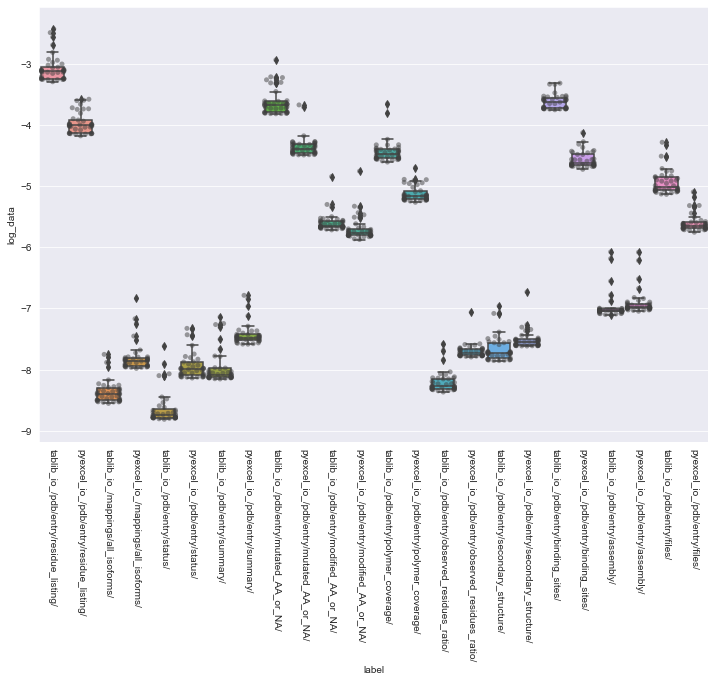

In [27]:
# plt.figure(figsize=(14,8))
f, ax = plt.subplots(figsize = (12, 8))
ax.set_xticklabels(ax.get_xticklabels(), rotation=-90)
'''
for i, j in recordDict.items():
    plt.plot(list(range(len(j))), j, label=i)
plt.legend(loc='upper left')
'''

dataLyst,labelLyst = [],[]

for i, j in recordDict.items():
    labelLyst.extend([i]*len(j))
    dataLyst.extend(j)

plot_dfrm = pd.DataFrame({'data': dataLyst, 'label': labelLyst})
plot_dfrm['module'] = plot_dfrm['label'].apply(lambda x: x.split('_')[0])
plot_dfrm['log_data'] = plot_dfrm['data'].apply(np.log)
sns.boxplot(x='label', y='log_data', data=plot_dfrm, ax = ax)
sns.swarmplot(x="label", y="log_data", data=plot_dfrm, color=".25", alpha=0.5, ax = ax)

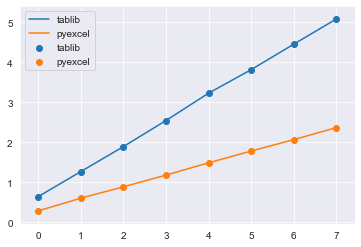

In [28]:
for module in plot_dfrm['module'].drop_duplicates():
    sumDict[module].append(plot_dfrm[plot_dfrm['module']==module]['data'].sum())
    plt.plot(list(range(len(sumDict[module]))), sumDict[module], label=module)
    plt.scatter(list(range(len(sumDict[module]))), sumDict[module], label=module)
plt.legend()

In [4]:
res_sheet = PDBeDecoder.tablib_io(
    '/pdb/entry/residue_listing/', 
    res_dict, 
    filename= r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1a01_residue_listing.tsv', 
    delimiter='\t')
res_sheet.df

,author_residue_number,author_insertion_code,observed_ratio,residue_name,residue_number,multiple_conformers,chain_id,struct_asym_id,entity_id,pdb_id
0,1,,1,VAL,1,None,A,A,1,1a01
1,2,,1,LEU,2,None,A,A,1,1a01
2,3,,1,SER,3,None,A,A,1,1a01
3,4,,1,PRO,4,None,A,A,1,1a01
4,5,,1,ALA,5,None,A,A,1,1a01
...,...,...,...,...,...,...,...,...,...,...
573,146,,1,HIS,146,None,D,D,2,1a01
574,147,,1,HEM,1,None,D,H,3,1a01
575,142,,1,HEM,1,None,A,E,3,1a01
576,142,,1,HEM,1,None,C,G,3,1a01


In [5]:
sifts_sheet = PDBeDecoder.tablib_io(
    '/mappings/all_isoforms/', 
    sifts_dict, 
    filename= r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1a01_sifts.tsv', 
    delimiter='\t')
sifts_sheet.df

,entity_id,end,chain_id,pdb_start,start,unp_end,pdb_end,struct_asym_id,unp_start,is_canonical,identity,pdb_id,UniProt,identifier,name
0,2,"{""author_residue_number"":146,""author_insertion...",B,1,"{""author_residue_number"":1,""author_insertion_c...",147,146,B,2,True,0.986,1a01,P68871,HBB_HUMAN,HBB_HUMAN
1,2,"{""author_residue_number"":146,""author_insertion...",D,1,"{""author_residue_number"":1,""author_insertion_c...",147,146,D,2,True,0.986,1a01,P68871,HBB_HUMAN,HBB_HUMAN
2,1,"{""author_residue_number"":141,""author_insertion...",A,1,"{""author_residue_number"":1,""author_insertion_c...",142,141,A,2,True,1.000,1a01,P69905,HBA_HUMAN,HBA_HUMAN
3,1,"{""author_residue_number"":141,""author_insertion...",C,1,"{""author_residue_number"":1,""author_insertion_c...",142,141,C,2,True,1.000,1a01,P69905,HBA_HUMAN,HBA_HUMAN


In [6]:
sifts_sheet2 = PDBeDecoder.tablib_io(
    '/mappings/all_isoforms/', 
    sifts_dict2, 
    filename= r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\Q9BQ50_sifts.tsv', 
    delimiter='\t')
sifts_sheet2.df

,entity_id,end,chain_id,start,unp_end,struct_asym_id,unp_start,is_canonical,identity,pdb_id,UniProt
0,1,"{""author_residue_number"":null,""author_insertio...",A,"{""author_residue_number"":1,""author_insertion_c...",236,A,1,True,1,1y97,Q9BQ50
1,1,"{""author_residue_number"":null,""author_insertio...",B,"{""author_residue_number"":null,""author_insertio...",236,B,1,True,1,1y97,Q9BQ50


In [7]:
status_sheet = PDBeDecoder.tablib_io(
    '/pdb/entry/status/', 
    status_dict, 
    filename= r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1a01,pppp,2xyn_status.tsv', 
    delimiter='\t')
status_sheet.df

,title,status_code,since,experimental_method_class,entry_authors,obsoletes,superceded_by,experimental_method,pdb_id
0,HUMAN ABL2 IN COMPLEX WITH AURORA KINASE INHIB...,REL,20101201,x-ray,"Salah, E., Ugochukwu, E., Elkins, J.M., Barr, ...","[""3nsv""]",[],X-RAY DIFFRACTION,2xyn
1,"HEMOGLOBIN (VAL BETA1 MET, TRP BETA37 ALA) MUTANT",REL,19980318,x-ray,"Kavanaugh, J.S., Arnone, A.",[],[],X-RAY DIFFRACTION,1a01


In [8]:
summary_sheet = PDBeDecoder.tablib_io(
    '/pdb/entry/summary/', 
    summary_dict, 
    filename= r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\1a01,2xyn,1miu_summary.tsv', 
    delimiter='\t')
summary_sheet.df

,related_structures,experimental_method,assemblies,title,release_date,split_entry,experimental_method_class,revision_date,entry_authors,deposition_site,number_of_entities,deposition_date,processing_site,pdb_id
0,[],"[""X-ray diffraction""]","[{""preferred"":true,""form"":""hetero"",""name"":""dim...",Structure of a BRCA2-DSS1 complex,20020925,[],"[""x-ray""]",20110713,"[""Yang, H."",""Jeffrey, P.D."",""Miller, J."",""Kinn...",RCSB,"{""water"":0,""polypeptide"":2,""other"":0,""dna"":0,""...",20020823,RCSB,1miu
1,[],"[""X-ray diffraction""]","[{""preferred"":true,""form"":""homo"",""name"":""monom...",HUMAN ABL2 IN COMPLEX WITH AURORA KINASE INHIB...,20101201,[],"[""x-ray""]",20190403,"[""Salah, E."",""Ugochukwu, E."",""Elkins, J.M."",""B...",PDBE,"{""water"":1,""polypeptide"":1,""other"":0,""dna"":0,""...",20101118,PDBE,2xyn
2,[],"[""X-ray diffraction""]","[{""preferred"":true,""form"":""hetero"",""name"":""tet...","HEMOGLOBIN (VAL BETA1 MET, TRP BETA37 ALA) MUTANT",19980318,[],"[""x-ray""]",20110713,"[""Kavanaugh, J.S."",""Arnone, A.""]",None,"{""water"":1,""polypeptide"":2,""other"":0,""dna"":0,""...",19971208,BNL,1a01


In [9]:
muta_sheet = PDBeDecoder.tablib_io(
    '/pdb/entry/mutated_AA_or_NA/', 
    muta_dict)
muta_sheet.df

,entity_id,residue_number,author_residue_number,chain_id,author_insertion_code,mutation_details,chem_comp_id,struct_asym_id,pdb_id
0,2,19,19.0,B,,"{""to"":""P"",""from"":""P"",""type"":""See remark 999""}",PRO,B,1zgu
1,2,24,24.0,B,,"{""to"":""E"",""from"":""E"",""type"":""See remark 999""}",GLU,B,1zgu
2,2,28,28.0,B,,"{""to"":""A"",""from"":""A"",""type"":""See remark 999""}",ALA,B,1zgu
3,2,48,48.0,B,,"{""to"":""R"",""from"":""K"",""type"":""Engineered mutati...",ARG,B,1zgu
4,1,75,76.0,A,,"{""to"":""A"",""from"":""K"",""type"":""Conflict""}",ALA,A,1zh9
...,...,...,...,...,...,...,...,...,...
215,1,337,NaN,A,,"{""to"":""H"",""from"":null,""type"":""Expression tag""}",HIS,A,1s9j
216,1,338,NaN,A,,"{""to"":""H"",""from"":null,""type"":""Expression tag""}",HIS,A,1s9j
217,1,339,NaN,A,,"{""to"":""H"",""from"":null,""type"":""Expression tag""}",HIS,A,1s9j
218,1,340,NaN,A,,"{""to"":""H"",""from"":null,""type"":""Expression tag""}",HIS,A,1s9j


In [10]:
mod_sheet = PDBeDecoder.tablib_io(
    '/pdb/entry/modified_AA_or_NA/', 
    mod_dict)
mod_sheet.df

,chem_comp_name,entity_id,residue_number,author_residue_number,chain_id,alternate_conformers,author_insertion_code,chem_comp_id,struct_asym_id,pdb_id
0,O-PHOSPHOTYROSINE,2,2,101,C,0,,PTR,B,1a07
1,O-PHOSPHOTYROSINE,2,2,101,D,0,,PTR,D,1a07
2,SELENOMETHIONINE,1,98,399,A,0,,MSE,A,1zgk
3,SELENOMETHIONINE,1,108,409,A,0,,MSE,A,1zgk
4,SELENOMETHIONINE,1,155,456,A,0,,MSE,A,1zgk
5,SELENOMETHIONINE,1,198,499,A,2,,MSE,A,1zgk
6,SELENOMETHIONINE,1,202,503,A,0,,MSE,A,1zgk
7,SELENOMETHIONINE,1,249,550,A,0,,MSE,A,1zgk
8,SELENOMETHIONINE,1,296,597,A,2,,MSE,A,1zgk
9,O-SULFO-L-TYROSINE,2,9,363,B,0,,TYS,B,1zgv


In [11]:
cov_sheet = PDBeDecoder.tablib_io(
    '/pdb/entry/polymer_coverage/', 
    cov_dict)
cov_sheet.df

,start,end,chain_id,struct_asym_id,entity_id,pdb_id
0,"{""author_residue_number"":135,""author_insertion...","{""author_residue_number"":140,""author_insertion...",A,A,1,1jdh
1,"{""author_residue_number"":151,""author_insertion...","{""author_residue_number"":548,""author_insertion...",A,A,1,1jdh
2,"{""author_residue_number"":560,""author_insertion...","{""author_residue_number"":663,""author_insertion...",A,A,1,1jdh
3,"{""author_residue_number"":12,""author_insertion_...","{""author_residue_number"":49,""author_insertion_...",B,B,2,1jdh
4,"{""author_residue_number"":1,""author_insertion_c...","{""author_residue_number"":166,""author_insertion...",A,A,1,121p
5,"{""author_residue_number"":1,""author_insertion_c...","{""author_residue_number"":130,""author_insertion...",A,A,1,133l
6,"{""author_residue_number"":61,""author_insertion_...","{""author_residue_number"":220,""author_insertion...",A,A,1,1s9j
7,"{""author_residue_number"":224,""author_insertion...","{""author_residue_number"":275,""author_insertion...",A,A,1,1s9j
8,"{""author_residue_number"":306,""author_insertion...","{""author_residue_number"":382,""author_insertion...",A,A,1,1s9j
9,"{""author_residue_number"":117,""author_insertion...","{""author_residue_number"":425,""author_insertion...",A,A,1,1mmk


In [12]:
ratio_sheet = PDBeDecoder.tablib_io(
    '/pdb/entry/observed_residues_ratio/', 
    ratio_dict)
ratio_sheet.df

,observed_ratio,chain_id,partial_ratio,number_residues,struct_asym_id,entity_id,pdb_id
0,1,A,0,137,A,1,1cbs
1,1,A,0,141,A,1,1a01
2,1,C,0,141,C,1,1a01
3,1,B,0,146,B,2,1a01
4,1,D,0,146,D,2,1a01


In [18]:
secStruct_sheet = PDBeDecoder.tablib_io(
    '/pdb/entry/secondary_structure/', 
    secStruct_dict)
secStruct_sheet.df

,end,sheet_id,start,secondary_structure,chain_id,struct_asym_id,entity_id,pdb_id
0,"{""author_residue_number"":22,""author_insertion_...",NaN,"{""author_residue_number"":14,""author_insertion_...",helices,A,A,1,1cbs
1,"{""author_residue_number"":37,""author_insertion_...",NaN,"{""author_residue_number"":25,""author_insertion_...",helices,A,A,1,1cbs
2,"{""author_residue_number"":13,""author_insertion_...",1.0,"{""author_residue_number"":5,""author_insertion_c...",strands,A,A,1,1cbs
3,"{""author_residue_number"":46,""author_insertion_...",1.0,"{""author_residue_number"":40,""author_insertion_...",strands,A,A,1,1cbs
4,"{""author_residue_number"":55,""author_insertion_...",1.0,"{""author_residue_number"":49,""author_insertion_...",strands,A,A,1,1cbs
5,"{""author_residue_number"":66,""author_insertion_...",1.0,"{""author_residue_number"":60,""author_insertion_...",strands,A,A,1,1cbs
6,"{""author_residue_number"":74,""author_insertion_...",1.0,"{""author_residue_number"":71,""author_insertion_...",strands,A,A,1,1cbs
7,"{""author_residue_number"":89,""author_insertion_...",1.0,"{""author_residue_number"":80,""author_insertion_...",strands,A,A,1,1cbs
8,"{""author_residue_number"":99,""author_insertion_...",1.0,"{""author_residue_number"":92,""author_insertion_...",strands,A,A,1,1cbs
9,"{""author_residue_number"":113,""author_insertion...",1.0,"{""author_residue_number"":107,""author_insertion...",strands,A,A,1,1cbs


In [19]:
bindSite_sheet = PDBeDecoder.tablib_io(
    '/pdb/entry/binding_sites/', 
    bindSite_dict)
bindSite_sheet.df

,author_insertion_code,author_residue_number,chain_id,chem_comp_id,entity_id,residue_number,struct_asym_id,symmetry_symbol,residues_type,details,evidence_code,site_id,pdb_id
0,None,294,A,LEU,1,40,A,1_555,site_residues,BINDING SITE FOR RESIDUE CL,Software,AC3,2xyn
1,None,295,A,GLY,1,41,A,1_555,site_residues,BINDING SITE FOR RESIDUE CL,Software,AC3,2xyn
2,None,297,A,GLY,1,43,A,1_555,site_residues,BINDING SITE FOR RESIDUE CL,Software,AC3,2xyn
3,None,298,A,GLN,1,44,A,1_555,site_residues,BINDING SITE FOR RESIDUE CL,Software,AC3,2xyn
4,None,299,A,TYR,1,45,A,1_555,site_residues,BINDING SITE FOR RESIDUE CL,Software,AC3,2xyn
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,None,70,D,ALA,2,70,D,1_555,site_residues,BINDING SITE FOR RESIDUE HEM,Software,AC4,1a01
146,None,63,D,HIS,2,63,D,1_555,site_residues,BINDING SITE FOR RESIDUE HEM,Software,AC4,1a01
147,None,41,D,PHE,2,41,D,1_555,site_residues,BINDING SITE FOR RESIDUE HEM,Software,AC4,1a01
148,None,437,D,HOH,4,40,L,1_555,site_residues,BINDING SITE FOR RESIDUE HEM,Software,AC4,1a01


In [15]:
assem_sheet = PDBeDecoder.tablib_io(
    '/pdb/entry/assembly/', 
    assem_dict)
assem_sheet.df

,entity_id,molecule_name,in_chains,molecule_type,number_of_copies,polymeric_count,assembly_composition,molecular_weight,details,assembly_id,pdb_id
0,1,"[""Tyrosine-protein kinase ABL2""]","[""A""]",polypeptide(L),1,1,protein structure,34.107,author_and_software_defined_assembly,1,2xyn
1,2,"[""SODIUM ION""]","[""D"",""G""]",Bound,2,1,protein structure,34.107,author_and_software_defined_assembly,1,2xyn
2,3,"[""CYCLOPROPANECARBOXYLIC ACID {4-[4-(4-METHYL-...","[""E""]",Bound,1,1,protein structure,34.107,author_and_software_defined_assembly,1,2xyn
3,4,"[""CHLORIDE ION""]","[""F""]",Bound,1,1,protein structure,34.107,author_and_software_defined_assembly,1,2xyn
4,5,"[""WATER""]","[""N""]",Water,1,1,protein structure,34.107,author_and_software_defined_assembly,1,2xyn
5,1,"[""Tyrosine-protein kinase ABL2""]","[""C""]",polypeptide(L),1,1,protein structure,34.937,author_and_software_defined_assembly,3,2xyn
6,3,"[""CYCLOPROPANECARBOXYLIC ACID {4-[4-(4-METHYL-...","[""K"",""L"",""M""]",Bound,3,1,protein structure,34.937,author_and_software_defined_assembly,3,2xyn
7,1,"[""Tyrosine-protein kinase ABL2""]","[""B""]",polypeptide(L),1,1,protein structure,34.955,author_and_software_defined_assembly,2,2xyn
8,3,"[""CYCLOPROPANECARBOXYLIC ACID {4-[4-(4-METHYL-...","[""H"",""I"",""J""]",Bound,3,1,protein structure,34.955,author_and_software_defined_assembly,2,2xyn
9,5,"[""WATER""]","[""O""]",Water,1,1,protein structure,34.955,author_and_software_defined_assembly,2,2xyn


In [16]:
associFile_sheet = PDBeDecoder.tablib_io(
    '/pdb/entry/files/', 
    associFile_dict)
associFile_sheet.df

,url,label,innerKey,key,pdb_id
0,http://www.ebi.ac.uk/pdbe/coordinates/files/2x...,EDS map,downloads,map,2xyn
1,http://www.ebi.ac.uk/pdbe/coordinates/files/2x...,EDS difference map,downloads,map,2xyn
2,http://www.ebi.ac.uk/pdbe/static/entry/downloa...,Assembly composition XML,downloads,assembly,2xyn
3,http://www.ebi.ac.uk/pdbe/static/entry/downloa...,Assembly 1 (mmCIF; gz),downloads,assembly,2xyn
4,http://www.ebi.ac.uk/pdbe/static/entry/downloa...,Assembly 2 (mmCIF; gz),downloads,assembly,2xyn
...,...,...,...,...,...
61,http://www.ebi.ac.uk/pdbe/entry-files/download...,Structure Factors,downloads,PDB,1a01
62,http://www.ebi.ac.uk/pdbe/entry-files/1a01.cif,Archive mmCIF file,views,PDB,1a01
63,http://www.ebi.ac.uk/pdbe/entry-files/1a01_upd...,Updated mmCIF file,views,PDB,1a01
64,http://www.ebi.ac.uk/pdbe/entry-files/pdb1a01.ent,PDB file,views,PDB,1a01
